<a href="https://colab.research.google.com/github/cyongkypranowo/DeepLearning-Gender-CLassification/blob/main/ResNet50-TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORT LIBRARY**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!pip install keras-tuner

In [49]:
import os
import shutil
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

import keras_tuner as kt
from keras.models import Model
from keras.models import Sequential, load_model
from keras.applications import VGG16
from keras.optimizers import Adam, RMSprop, SGD
from keras.utils import image_dataset_from_directory
from keras.layers import Input, Flatten, Dense, Dropout, Conv2D, BatchNormalization, ReLU, AveragePooling2D
from keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
# from tensorflow.keras.layers import Conv2D


In [8]:
# Load data from list_attr_celeba.txt
df = pd.read_csv('/content/drive/MyDrive/ResNet/list_attribute.txt', sep="\s+", skiprows=1, usecols=['Male'])
df.index.name = 'filename'
df.replace(to_replace=-1, value=0, inplace=True)
df.loc[df['Male'] == -1, 'Male'] = 0
df.rename(columns={"Male": "is_male"}, inplace=True)


In [9]:
image_files = os.listdir('/content/drive/MyDrive/ResNet/Images/')
filtered_df = df[df.index.isin(image_files)]
filtered_df.reset_index(drop=False, inplace=True)

In [10]:
filtered_df.reset_index(drop=False, inplace=True)
filtered_df

,index,filename,is_male
0,0,000051.jpg,1
1,1,000052.jpg,1
2,2,000065.jpg,1
3,3,000166.jpg,1
4,4,000198.jpg,0
...,...,...,...
4995,4995,202320.jpg,0
4996,4996,202340.jpg,0
4997,4997,202347.jpg,0
4998,4998,202357.jpg,0


In [11]:
images_path = '/content/drive/MyDrive/ResNet/Images'
splitted_folder = '/content/drive/MyDrive/ResNet/Splitted'
train_folder = os.path.join(splitted_folder, 'Train')
validation_folder = os.path.join(splitted_folder, 'Validation')
test_folder = os.path.join(splitted_folder, 'Test')

In [12]:
os.makedirs(train_folder, exist_ok=True)
os.makedirs(validation_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

In [13]:
for index, row in filtered_df.iterrows():
    filename = row['filename']
    is_male_label = row['is_male']

    if index % 10 < 8:
        current_folder = train_folder
    elif index % 10 == 8:
        current_folder = validation_folder
    else:
        current_folder = test_folder

    if is_male_label == 0:
        is_male_folder = os.path.join(current_folder, 'Female')
    else:
        is_male_folder = os.path.join(current_folder, 'Male')

    os.makedirs(is_male_folder, exist_ok=True)

    source_path = os.path.join(images_path, filename)
    destination_path = os.path.join(is_male_folder, filename)

    if not os.path.exists(destination_path):
        print(f'Copying file {source_path} to {is_male_folder}')
        shutil.copy(source_path, destination_path)
    else:
        print(f'File {filename} already exists in {is_male_folder}, skipping.')

print('Splitting Datasets completed')

Output streaming akan dipotong hingga 5000 baris terakhir.
File 000052.jpg already exists in /content/drive/MyDrive/ResNet/Splitted/Train/Male, skipping.
File 000065.jpg already exists in /content/drive/MyDrive/ResNet/Splitted/Train/Male, skipping.
File 000166.jpg already exists in /content/drive/MyDrive/ResNet/Splitted/Train/Male, skipping.
File 000198.jpg already exists in /content/drive/MyDrive/ResNet/Splitted/Train/Female, skipping.
File 000201.jpg already exists in /content/drive/MyDrive/ResNet/Splitted/Train/Female, skipping.
File 000240.jpg already exists in /content/drive/MyDrive/ResNet/Splitted/Train/Female, skipping.
File 000282.jpg already exists in /content/drive/MyDrive/ResNet/Splitted/Train/Male, skipping.
File 000352.jpg already exists in /content/drive/MyDrive/ResNet/Splitted/Validation/Male, skipping.
File 000409.jpg already exists in /content/drive/MyDrive/ResNet/Splitted/Test/Male, skipping.
File 000414.jpg already exists in /content/drive/MyDrive/ResNet/Splitted/Tra

In [14]:
def build_resnet50(hp):
    input_shape = (178, 218, 3)
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = AveragePooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)

    num_hidden_layers = hp.Int('num_hidden_layers', min_value=1, max_value=5, step=1)
    for i in range(num_hidden_layers):
        num_units = hp.Choice(f'num_units_{i}', values=[128, 256, 512])
        dropout_rate = hp.Float(f'dropout_rate_{i}', min_value=0.1, max_value=0.9, step=0.1)

        x = Dense(num_units, activation='relu')(x)
        x = Dropout(dropout_rate)(x)

    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=outputs)

    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    learning_rate = hp.Choice('learning_rate', values=[1e-5, 1e-4, 1e-3, 3e-3, 1e-2, 3e-2, 0.1, 0.3])

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [15]:
# model = resnet34((178, 218, 3), 2) # 2 = male & female, 2 class
# model.summary()

In [16]:
# Compile the model with an optimizer, loss function, and evaluation metric
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
image_size=(178, 218);
batch_size=32;

In [18]:
# Load the CelebA dataset Train
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_folder,
    seed=random.randint(1, 1000),
    label_mode='binary',
    image_size=image_size,
    batch_size=batch_size
)

Found 4000 files belonging to 2 classes.


In [19]:
# Load the CelebA dataset validation
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=validation_folder,
    seed=random.randint(1, 1000),
    label_mode='binary',
    image_size=image_size,
    batch_size=batch_size
)


Found 500 files belonging to 2 classes.


In [20]:
# load the CelebA dataset test
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_folder,
    seed=random.randint(1, 1000),
    label_mode='binary',
    image_size=image_size,
    batch_size=batch_size
)


Found 500 files belonging to 2 classes.


In [42]:
epochs = 100
# input_shape = (178, 218, 3)
# num_classes = 2
hp_opz = ['hyperband', 'RandomSearch', 'Bayesian']

In [22]:
hyperband_tuner = kt.Hyperband(
    build_resnet50,
    objective='val_accuracy',
    max_epochs=epochs,
    factor=3,
    seed=42,
    directory='/content/drive/MyDrive/ResNet/tuner',
    project_name=str(hp_opz[0])
)


Reloading Tuner from /content/drive/MyDrive/ResNet/tuner/hyperband/tuner0.json


In [ ]:
# Start the hyperparameter search
hyperband_tuner.search(train_ds, validation_data=validation_ds, epochs=epochs)

In [37]:
best_hyperband_param = hyperband_tuner.get_best_hyperparameters(num_trials=1)[0]

cp = ModelCheckpoint('/content/drive/MyDrive/ResNet/Model/Restnet50-with-{}-Optimization.h5'.format(hp_opz[0]), monitor='val_loss', save_best_only=True,
                     save_weights_only=False, mode='auto', save_freq='epoch', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=25)

best_hyperband_model = hyperband_tuner.hypermodel.build(best_hyperband_param)
best_hyperband_model = best_hyperband_model.fit(train_ds, validation_data=(test_ds), epochs=epochs,
                                                batch_size=batch_size, callbacks=[cp, early_stopping], shuffle=True)

Epoch 1/10
125/125 [==============================] - ETA: 0s - loss: 1.3147 - accuracy: 0.7490
Epoch 1: val_loss improved from inf to 0.23291, saving model to /content/drive/MyDrive/ResNet/Model/Restnet50-with-hyperband-Optimization.h5
125/125 [==============================] - 14s 76ms/step - loss: 1.3147 - accuracy: 0.7490 - val_loss: 0.2329 - val_accuracy: 0.8940
Epoch 2/10
125/125 [==============================] - ETA: 0s - loss: 0.3272 - accuracy: 0.8823
Epoch 2: val_loss improved from 0.23291 to 0.21945, saving model to /content/drive/MyDrive/ResNet/Model/Restnet50-with-hyperband-Optimization.h5
125/125 [==============================] - 9s 67ms/step - loss: 0.3272 - accuracy: 0.8823 - val_loss: 0.2194 - val_accuracy: 0.9020
Epoch 3/10
125/125 [==============================] - ETA: 0s - loss: 0.2489 - accuracy: 0.9020
Epoch 3: val_loss improved from 0.21945 to 0.20792, saving model to /content/drive/MyDrive/ResNet/Model/Restnet50-with-hyperband-Optimization.h5
125/125 [=======

In [32]:
randomsearch_tuner = kt.RandomSearch(
    build_resnet50,
    objective='val_accuracy',
    max_trials=10,
    seed=42,
    executions_per_trial=1,
    directory='tuner',
    project_name=str(hp_opz[1])
)

In [ ]:
best_randomsearch_param = {}
randomsearch_tuner.search(train_ds, validation_data=(validation_ds), epochs=epochs, batch_size=batch_size, shuffle=True)

randomsearch_results = randomsearch_tuner.results_summary()

In [36]:
best_randomsearch_param = randomsearch_tuner.get_best_hyperparameters(num_trials=1)[0]

cp = ModelCheckpoint('/content/drive/MyDrive/ResNet/Model/Restnet50-with-{}-Optimization.h5'.format(hp_opz[1]), monitor='val_loss', save_best_only=True,
                     save_weights_only=False, mode='auto', save_freq='epoch', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=25)

best_randomsearch_model = randomsearch_tuner.hypermodel.build(best_randomsearch_param)
best_randomsearch_model = best_randomsearch_model.fit(train_ds, validation_data=(test_ds), epochs=epochs,
                                                batch_size=16, callbacks=[cp, early_stopping], shuffle=True)

Epoch 1/10
124/125 [============================>.] - ETA: 0s - loss: 0.4089 - accuracy: 0.8417
Epoch 1: val_loss improved from inf to 0.20492, saving model to /content/drive/MyDrive/ResNet/Model/Restnet50-with-RandomSearch-Optimization.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 14s 75ms/step - loss: 0.4073 - accuracy: 0.8422 - val_loss: 0.2049 - val_accuracy: 0.9100
Epoch 2/10
125/125 [==============================] - ETA: 0s - loss: 0.2352 - accuracy: 0.9120
Epoch 2: val_loss improved from 0.20492 to 0.20061, saving model to /content/drive/MyDrive/ResNet/Model/Restnet50-with-RandomSearch-Optimization.h5
125/125 [==============================] - 9s 69ms/step - loss: 0.2352 - accuracy: 0.9120 - val_loss: 0.2006 - val_accuracy: 0.9180
Epoch 3/10
125/125 [==============================] - ETA: 0s - loss: 0.1872 - accuracy: 0.9293
Epoch 3: val_loss did not improve from 0.20061
125/125 [==============================] - 7s 54ms/step - loss: 0.1872 - accuracy: 0.9293 - val_loss: 0.2131 - val_accuracy: 0.9160
Epoch 4/10
124/125 [============================>.] - ETA: 0s - loss: 0.1779 - accuracy: 0.9330
Epoch 4: val_loss did not improve from 0.20061
125/125 [==============================] - 7s 56ms/step - loss: 0.1778 - 

In [38]:
bayesian_tuner = kt.BayesianOptimization(
    build_resnet50,
    objective='val_accuracy',
    max_trials=10,
    seed=42,
    directory='tuner',
    project_name=str(hp_opz[2])
)

In [ ]:
best_bayesian_param = {}
bayesian_tuner.search(train_ds, validation_data=(validation_ds), epochs=epochs, batch_size=batch_size, shuffle=True)

bayesian_results = bayesian_tuner.results_summary()

In [43]:
best_bayesian_param = bayesian_tuner.get_best_hyperparameters(num_trials=1)[0]

cp = ModelCheckpoint('/content/drive/MyDrive/ResNet/Model/ResNet50-with-{}-Optimization.h5'.format(hp_opz[2]), monitor='val_loss', save_best_only=True,
                     save_weights_only=False, mode='auto', save_freq='epoch', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=25)

best_bayesian_model = bayesian_tuner.hypermodel.build(best_bayesian_param)
best_bayesian_model = best_bayesian_model.fit(train_ds, validation_data=(test_ds), epochs=epochs,
                                                batch_size=16, callbacks=[cp, early_stopping], shuffle=True)

Epoch 1/100
125/125 [==============================] - ETA: 0s - loss: 0.3770 - accuracy: 0.8493
Epoch 1: val_loss improved from inf to 0.23971, saving model to /content/drive/MyDrive/ResNet/Model/ResNet50-with-Bayesian-Optimization.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 14s 76ms/step - loss: 0.3770 - accuracy: 0.8493 - val_loss: 0.2397 - val_accuracy: 0.9000
Epoch 2/100
124/125 [============================>.] - ETA: 0s - loss: 0.2374 - accuracy: 0.9123
Epoch 2: val_loss did not improve from 0.23971
125/125 [==============================] - 7s 55ms/step - loss: 0.2371 - accuracy: 0.9122 - val_loss: 0.2468 - val_accuracy: 0.9100
Epoch 3/100
125/125 [==============================] - ETA: 0s - loss: 0.2012 - accuracy: 0.9183
Epoch 3: val_loss did not improve from 0.23971
125/125 [==============================] - 8s 57ms/step - loss: 0.2012 - accuracy: 0.9183 - val_loss: 0.2929 - val_accuracy: 0.8800
Epoch 4/100
124/125 [============================>.] - ETA: 0s - loss: 0.1856 - accuracy: 0.9267
Epoch 4: val_loss improved from 0.23971 to 0.22413, saving model to /content/drive/MyDrive/ResNet/Model/ResNet50-with-Bayesian-Optimization.h5
125/125 [==============================] - 10s 73ms/step - loss: 0.1853 - a

In [28]:
restnet50_hyperband = load_model('/content/drive/MyDrive/ResNet/Model/Restnet50-with-hyperband-Optimization.h5')

loss, accuracy = restnet50_hyperband.evaluate(test_ds)
print(f'RestNet50 with Hyperband Tuning model loss: {loss}, accuracy: {accuracy}')

16/16 [==============================] - 2s 38ms/step - loss: 0.2109 - accuracy: 0.9140
RestNet50 with Hyperband Tuning model loss: 0.21089692413806915, accuracy: 0.9139999747276306


In [44]:
restnet50_random_search = load_model('/content/drive/MyDrive/ResNet/Model/Restnet50-with-RandomSearch-Optimization.h5')

loss, accuracy = restnet50_random_search.evaluate(test_ds)
print(f'RestNet50 with Random Search Tuning model loss: {loss}, accuracy: {accuracy}')

16/16 [==============================] - 2s 39ms/step - loss: 0.2006 - accuracy: 0.9180
RestNet50 with Random Search Tuning model loss: 0.2006130814552307, accuracy: 0.9179999828338623


In [46]:
restnet50_bayesian = load_model('/content/drive/MyDrive/ResNet/Model/ResNet50-with-Bayesian-Optimization.h5')

loss, accuracy = restnet50_bayesian.evaluate(test_ds)
print(f'RestNet50 with Random Search Tuning model loss: {loss}, accuracy: {accuracy}')

16/16 [==============================] - 2s 38ms/step - loss: 0.2177 - accuracy: 0.9260
RestNet50 with Random Search Tuning model loss: 0.21767744421958923, accuracy: 0.9259999990463257


1/1 [==============================] - 1s 1s/step


<ipython-input-47-b9a8b5f02ca7>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_label = class_names[int(np.round(predictions[i]))]


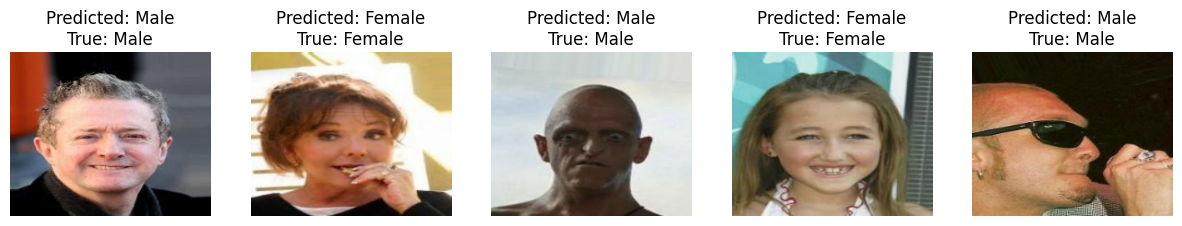

In [47]:
def display_sample_predictions(model, dataset, class_names, num_samples=5):
    plt.figure(figsize=(15, 10))
    for images, labels in dataset.take(1):
        predictions = model.predict(images)
        for i in range(num_samples):
            ax = plt.subplot(1, num_samples, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            predicted_label = class_names[int(np.round(predictions[i]))]
            true_label = class_names[int(labels[i])]
            plt.title(f'Predicted: {predicted_label}\nTrue: {true_label}')
            plt.axis("off")

# Load the class names
class_names = train_ds.class_names

# Assuming you have loaded your trained model with the best hyperparameters
# and stored it in the variable 'restnet50_hyperband'
# and you have a test dataset 'test_ds'
# Display sample predictions using the hyperband-tuned model
display_sample_predictions(restnet50_hyperband, test_ds, class_names)
plt.show()

1/1 [==============================] - 0s 23ms/step


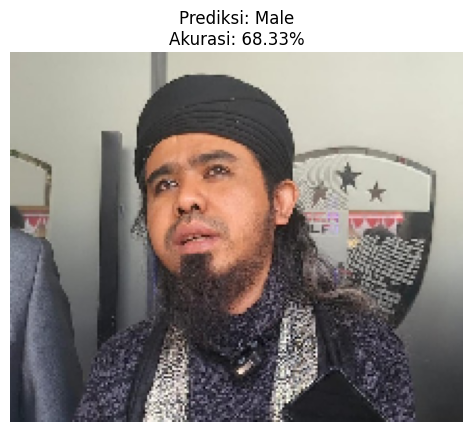

In [60]:
# Path ke gambar yang ingin Anda prediksi
image_path = '/content/drive/MyDrive/ResNet/TesFigureIndonesia/tes1.jpeg'

# Load gambar dan resize sesuai ukuran yang diharapkan oleh model (178x218)
img = image.load_img(image_path, target_size=(178, 218))

# Konversi gambar menjadi array numpy
img_array = image.img_to_array(img)

# Perlu direshape menjadi bentuk yang dapat diterima oleh model (menambahkan dimensi batch)
img_array = np.expand_dims(img_array, axis=0)

# Normalisasi nilai piksel
img_array /= 255.0

# Lakukan prediksi menggunakan model yang telah diload
predictions = restnet50_hyperband.predict(img_array)

# Karena keluaran model adalah probabilitas, kita mungkin perlu menentukan threshold untuk menentukan kelas mana yang diprediksi
threshold = 0.5  # Contoh threshold, bisa disesuaikan sesuai kebutuhan
predicted_class = "Male" if predictions[0][0] > threshold else "Female"
accuracy_percentage = predictions[0][0] if predicted_class == "Male" else 1 - predictions[0][0]

# Tampilkan gambar
plt.imshow(img)
plt.axis('off')
plt.title(f'Prediksi: {predicted_class}\nAkurasi: {accuracy_percentage * 100:.2f}%')
plt.show()